Nikhil Chapkanade 20230802111


X_train shape: (13, 142)
y_train shape: (3, 142)
Epoch 0, Loss: 1.098028214091132
Epoch 100, Loss: 0.11931633212530351
Epoch 200, Loss: 0.04520008375457141
Epoch 300, Loss: 0.02762512882916862
Epoch 400, Loss: 0.01964407340487328
Epoch 500, Loss: 0.015068051175418755
Epoch 600, Loss: 0.012116343879343636
Epoch 700, Loss: 0.010067726745003409
Epoch 800, Loss: 0.008571223193933228
Epoch 900, Loss: 0.007435367896090824
Epoch 1000, Loss: 0.006547071938001521
Epoch 1100, Loss: 0.0058354470669483086
Epoch 1200, Loss: 0.005253935661985622
Epoch 1300, Loss: 0.0047707807796415185
Epoch 1400, Loss: 0.004363629393548799
Epoch 1500, Loss: 0.004016323668592304
Epoch 1600, Loss: 0.0037169142382125295
Epoch 1700, Loss: 0.003456387060269731
Epoch 1800, Loss: 0.003227823021962736
Epoch 1900, Loss: 0.003025828681874203

Training complete.

Final Test Accuracy: 100.00%


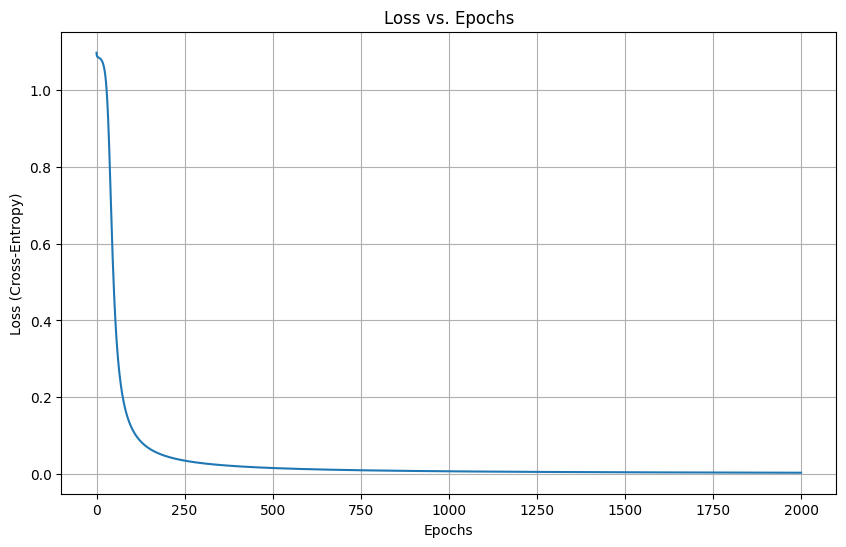

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ----------------------------------------------------------------
# 1. LOAD AND PREPROCESS THE WINE DATASET [cite: 25]
# ----------------------------------------------------------------

# Load dataset
wine = load_wine()
X = wine.data
y = wine.target.reshape(-1, 1)

# --- Preprocessing ---
# Scale features (important for ANNs)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode labels (for cross-entropy loss)
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Transpose for our ANN implementation (features x samples)
X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

print(f"X_train shape: {X_train.shape}") # (13 features, 142 samples)
print(f"y_train shape: {y_train.shape}") # (3 classes, 142 samples)

# ----------------------------------------------------------------
# 2. DEFINE ANN ARCHITECTURE AND HELPER FUNCTIONS
# ----------------------------------------------------------------

# Define network dimensions
n_x = X_train.shape[0]  # Input layer nodes (13 features)
n_h = 8                 # Hidden layer nodes (you can tune this)
n_y = y_train.shape[0]  # Output layer nodes (3 classes)
m = X_train.shape[1]    # Number of training examples

# Activation Functions
def sigmoid(Z):
    """Sigmoid activation for hidden layer"""
    A = 1 / (1 + np.exp(-Z))
    return A

def softmax(Z):
    """Softmax activation for output layer"""
    # Shift Z by max(Z) for numerical stability
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = expZ / np.sum(expZ, axis=0, keepdims=True)
    return A

# ----------------------------------------------------------------
# 3. INITIALIZE WEIGHTS AND BIASES [cite: 26]
# ----------------------------------------------------------------
def initialize_parameters(n_x, n_h, n_y):
    """Initializes weights and biases with small random values"""
    np.random.seed(42)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

# ----------------------------------------------------------------
# 4. FORWARD PROPAGATION [cite: 27]
# ----------------------------------------------------------------
def forward_propagation(X, parameters):
    """Performs one forward pass through the network"""
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # Hidden Layer
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    # Output Layer
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

# ----------------------------------------------------------------
# 5. COMPUTE LOSS (CROSS-ENTROPY) [cite: 28]
# ----------------------------------------------------------------
def compute_loss(A2, Y):
    """Computes cross-entropy loss"""
    m = Y.shape[1] # Number of examples
    # Add a small epsilon (1e-8) for numerical stability
    logprobs = np.multiply(Y, np.log(A2 + 1e-8))
    loss = - (1/m) * np.sum(logprobs)
    loss = np.squeeze(loss) # Make sure loss is a scalar
    return loss

# ----------------------------------------------------------------
# 6. BACKWARD PROPAGATION [cite: 29]
# ----------------------------------------------------------------
def backward_propagation(parameters, cache, X, Y):
    """Performs one backward pass to calculate gradients"""
    m = X.shape[1]

    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']

    # --- Output Layer ---
    # Gradient of Loss w.r.t Z2 (for softmax + cross-entropy)
    dZ2 = A2 - Y

    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # --- Hidden Layer ---
    dA1 = np.dot(W2.T, dZ2)
    # Gradient of Loss w.r.t Z1 (derivative of sigmoid is A1 * (1 - A1))
    dZ1 = dA1 * (A1 * (1 - A1))

    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

# ----------------------------------------------------------------
# 7. UPDATE WEIGHTS
# ----------------------------------------------------------------
def update_parameters(parameters, grads, learning_rate):
    """Updates weights and biases using gradient descent"""
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

# ----------------------------------------------------------------
# 8. TRAIN THE MODEL [cite: 30]
# ----------------------------------------------------------------
def ann_model(X_train, y_train, n_h, num_epochs, learning_rate):
    """Main function to train the neural network"""
    n_x = X_train.shape[0]
    n_y = y_train.shape[0]

    parameters = initialize_parameters(n_x, n_h, n_y)
    losses = []

    for i in range(num_epochs):
        # Forward propagation
        A2, cache = forward_propagation(X_train, parameters)

        # Compute loss
        loss = compute_loss(A2, y_train)
        losses.append(loss)

        # Backward propagation
        grads = backward_propagation(parameters, cache, X_train, y_train)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0:
            print(f"Epoch {i}, Loss: {loss}")

    return parameters, losses

# --- Set hyperparameters and train ---
num_epochs = 2000
learning_rate = 0.5
trained_parameters, losses = ann_model(X_train, y_train, n_h, num_epochs, learning_rate)

print("\nTraining complete.")

# ----------------------------------------------------------------
# 9. EVALUATE THE MODEL [cite: 31]
# ----------------------------------------------------------------
def predict(X, parameters):
    """Make predictions on new data"""
    A2, _ = forward_propagation(X, parameters)
    # Get the index of the highest probability
    predictions = np.argmax(A2, axis=0)
    return predictions

# --- Test Accuracy ---
test_predictions = predict(X_test, trained_parameters)
# Convert one-hot y_test back to class labels
test_true_labels = np.argmax(y_test, axis=0)

accuracy = np.mean(test_predictions == test_true_labels) * 100
print(f"\nFinal Test Accuracy: {accuracy:.2f}%") # [cite: 36]

# ----------------------------------------------------------------
# 10. PLOT LOSS CURVE [cite: 33, 37]
# ----------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss (Cross-Entropy)")
plt.grid(True)
plt.show()

Nikhil Chapkanade 20230802111


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (60000, 28, 28)
y_train_onehot shape: (60000, 10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6594 - loss: 1.2027 - val_accuracy: 0.8310 - val_loss: 0.6398
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8311 - loss: 0.6469 - val_accuracy: 0.8597 - val_loss: 0.5454
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8460 - loss: 0.5699 - val_accuracy: 0.8550 - val_loss: 0.5214
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8558 - loss: 0.5254 - val_accuracy: 0.8685 - val_loss: 0.4833
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8561 - loss: 0.5126 - val_accuracy: 0.8660 - val_loss: 0.4735
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8580 - loss: 0.4906 - val_accuracy: 0.8717 - val_loss: 0.4548
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8604 - loss: 0.4839 - val_accuracy: 0.8675 - val_loss: 0.4524
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8622 - los

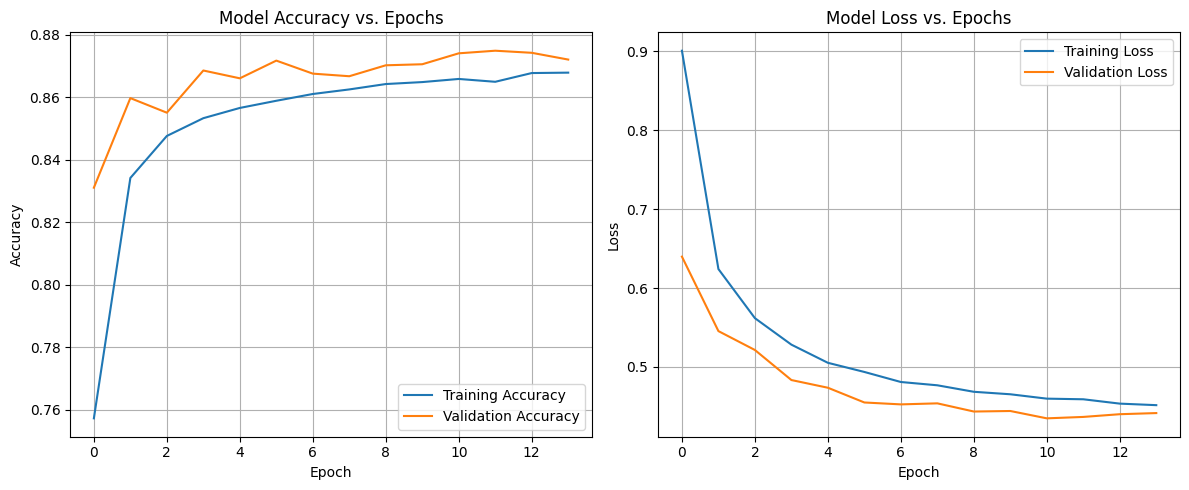

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


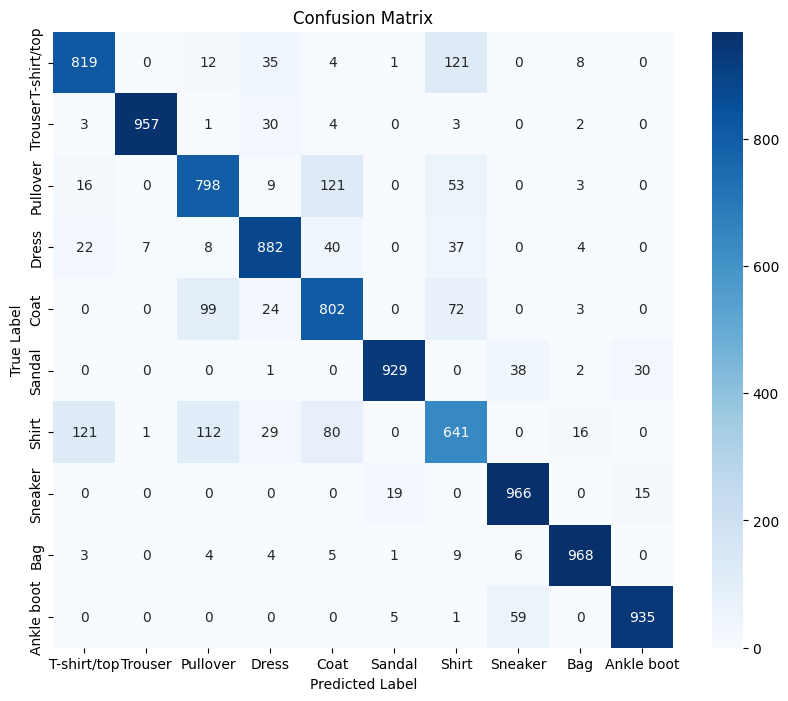

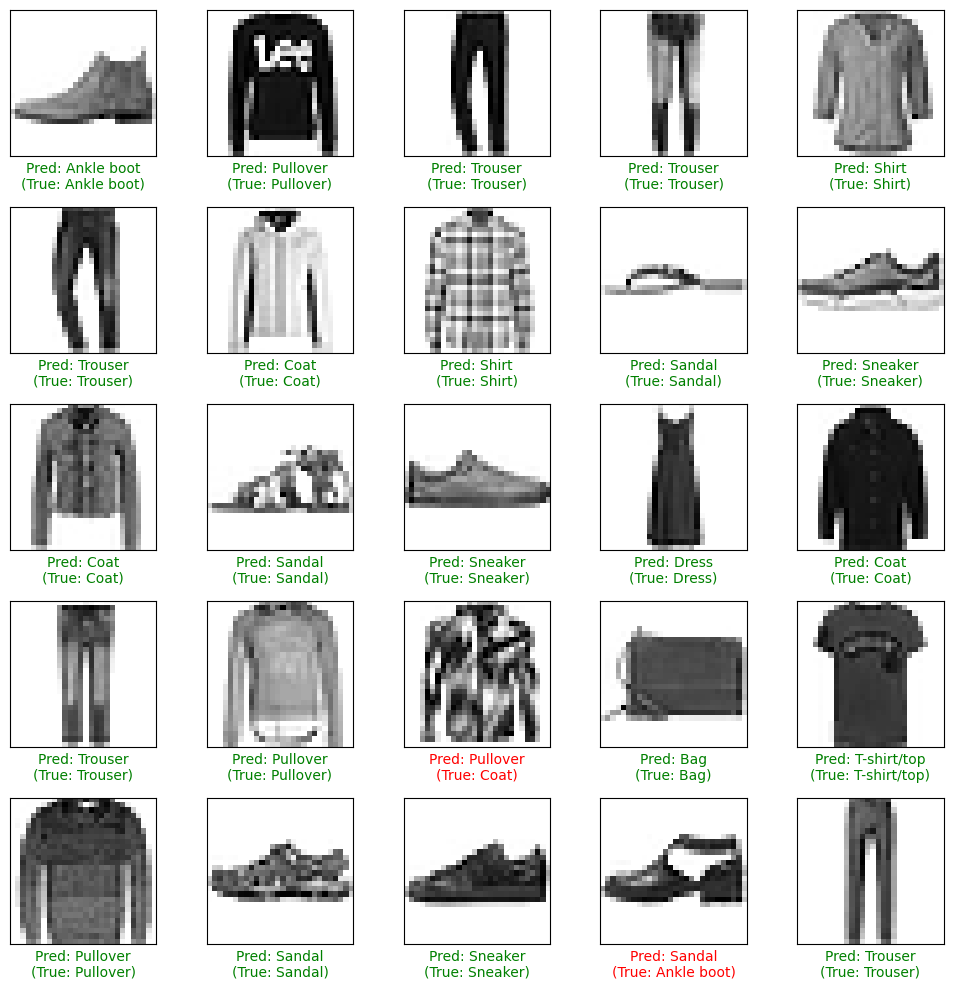

In [ ]:
import tensorflow as tf
from tensorflow import keras
# Import the fashion_mnist dataset
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ----------------------------------------------------------------
# 1. LOAD AND PREPROCESS THE FASHION-MNIST DATASET
# ----------------------------------------------------------------

# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Define the class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalize input values from 0-255 to 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode output labels
y_train_onehot = keras.utils.to_categorical(y_train, 10)
y_test_onehot = keras.utils.to_categorical(y_test, 10)

print(f"X_train shape: {X_train.shape}")
print(f"y_train_onehot shape: {y_train_onehot.shape}")

# ----------------------------------------------------------------
# 2. DEFINE NEURAL NETWORK ARCHITECTURE
# ----------------------------------------------------------------
model = Sequential()

# Flatten images into 1D array (784 features)
# Input shape is (28, 28)
model.add(Flatten(input_shape=(28, 28)))

# Hidden Layer 1: 128 neurons, ReLU activation
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2)) # Add dropout

# Hidden Layer 2: 64 neurons, ReLU activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2)) # Add dropout

# Output Layer: 10 neurons, Softmax activation
model.add(Dense(10, activation='softmax'))

# ----------------------------------------------------------------
# 3. COMPILE THE MODEL
# ----------------------------------------------------------------

# Use Adam optimizer and cross-entropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implement Early Stopping
# Stops training if validation loss doesn't improve for 3 epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

# ----------------------------------------------------------------
# 4. TRAIN THE MODEL
# ----------------------------------------------------------------

print("\nStarting model training...")
history = model.fit(X_train, y_train_onehot,
                    epochs=50,  # High number, but Early Stopping will halt it
                    batch_size=128,
                    validation_split=0.1, # Use 10% of training data for validation
                    callbacks=[early_stopper])
print("Training complete.")

# ----------------------------------------------------------------
# 5. EVALUATE THE MODEL
# ----------------------------------------------------------------

print("\n--- Model Evaluation ---")
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=2)
# You should see accuracy much closer to the expected 95%
print(f"Test Accuracy: {test_acc*100:.2f}%")

# ----------------------------------------------------------------
# 6. PLOT ACCURACY AND LOSS CURVES
# ----------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 7. DISPLAY CONFUSION MATRIX AND SAMPLE PREDICTIONS
# ----------------------------------------------------------------

# --- Confusion Matrix ---
# Get model predictions (as class probabilities)
y_pred_probs = model.predict(X_test)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred) # y_test contains the original labels (0-9)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Sample Predictions ---
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    predicted_label = y_pred[i]
    true_label = y_test[i]

    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"Pred: {class_names[predicted_label]}\n(True: {class_names[true_label]})", color=color)

plt.tight_layout()
plt.show()